# KE5105 - Building Electrical Consumption Forecasting

# Modelling 4 - Preliminary model

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [26]:
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
 print("# of CPU: {0}".format(psutil.cpu_count()))
printm()

Gen RAM Free: 12.3 GB  | Proc size: 992.8 MB
GPU RAM Free: 11047MB | Used: 394MB | Util   3% | Total 11441MB
# of CPU: 2


In [0]:
# from google.colab import files
# files.upload()

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ls -l /content/gdrive/My\ Drive/python

total 10334
-rw------- 1 root root 10291100 Jan  3 03:28 AS5.csv
-rw------- 1 root root    42400 Jan  4 05:53 base-rnn-nomask-16x16-val.h5
-rw------- 1 root root    47136 Jan  7 06:11 base-rnn-nomask-32-val.h5
-rw------- 1 root root   122920 Jan  7 08:27 base-rnn-nomask-64-val.h5
-rw------- 1 root root    25696 Jan  3 09:47 base-rnn-nomask-val.h5
-rw------- 1 root root     7602 Jan  3 03:28 bldg-BTU-formulae.json
-rw------- 1 root root    17781 Jan  3 03:28 bldg-PWM-formulae.json
-rw------- 1 root root    25431 Jan  7 01:47 myUtilities.py


In [0]:
!cp /content/gdrive/My\ Drive/python/myUtilities.py ./

## Load libraries

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
import numpy as np
import datetime
import myUtilities as mu

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Load data for building AS5

In [0]:
as5 = mu.load_data_by_bldg(['AS5'], 'processed')

In [0]:
as5[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         46164 non-null float64
PWMEXTAS4ExBldg                   46165 non-null float64
PWMAS4LanguageCenter              46165 non-null float64
PWMCANTEEN                        46164 non-null float64
PWMStreetLight                    46164 non-null float64
BTUAS5                            46175 non-null float64
PWMMainIC_30min_avg               46117 non-null float64
PWMEXTAS4ExBldg_30min_avg         46118 non-null float64
PWMAS4LanguageCenter_30min_avg    46118 non-null float64
PWMCANTEEN_30min_avg              46117 non-null float64
PWMStreetLight_30min_avg          46117 non-null float64
BTUAS5_30min_avg                  46129 non-null float64
PWM_sumadd                        46117 non-null float64
PWM_sumsubtract                   46117 non-null float64
PWM_30min_avg                     46117 non-null float64
B

## Split the data into train and test set

In [0]:
as5_train_df = as5[0][1].loc['2015-06-12 08:00:00':'2017-03-31 23:30:00', :]

In [0]:
as5_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     29985 non-null float64
B

In [0]:
as5_test_df = as5[0][1].loc['2018-01-01 00:00:00':, :]

In [0]:
as5_test_df.index.max()

Timestamp('2018-12-31 23:30:00')

In [0]:
as5_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2018-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         16145 non-null float64
PWMEXTAS4ExBldg                   16145 non-null float64
PWMAS4LanguageCenter              16145 non-null float64
PWMCANTEEN                        16145 non-null float64
PWMStreetLight                    16145 non-null float64
BTUAS5                            16144 non-null float64
PWMMainIC_30min_avg               16132 non-null float64
PWMEXTAS4ExBldg_30min_avg         16132 non-null float64
PWMAS4LanguageCenter_30min_avg    16132 non-null float64
PWMCANTEEN_30min_avg              16132 non-null float64
PWMStreetLight_30min_avg          16132 non-null float64
BTUAS5_30min_avg                  16130 non-null float64
PWM_sumadd                        16132 non-null float64
PWM_sumsubtract                   16132 non-null float64
PWM_30min_avg                     16132 non-null float64
B

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [0]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## Normalise the training data

* Convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [0]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [12]:
as5_train_data = my_pipeline.fit_transform(as5_train_df)
as5_train_data

array([[ 0.26254935,  0.56924225],
       [ 0.26724948,  0.53427896],
       [ 0.28031585,  0.53353241],
       ...,
       [ 0.12897161,  0.03222595],
       [ 0.10312089,  0.00348389],
       [-1.        , -1.        ]])

## Split a validation set out from the train set

In [0]:
as5_train_split = as5_train_data[:20000]
as5_val_split = as5_train_data[20000:]

In [0]:
print('train split = %s\nvalidation split = %s' % (as5_train_split.shape, as5_val_split.shape))

train split = (20000, 2)
validation split = (11616, 2)


## Base RNN Model (32 nodes)

In [0]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [0]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [0]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=80,
                              validation_data=gen_val,
                              workers=4, use_multiprocessing=True, shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/80
143/143 [==============================] - 69s 483ms/step - loss: 0.0463 - mean_absolute_percentage_error: 27.4386 - val_loss: 0.0324 - val_mean_absolute_percentage_error: 15.4350
Epoch 2/80Epoch 1/80

143/143 [==============================] - 69s 485ms/step - loss: 0.0254 - mean_absolute_percentage_error: 17.1317 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 13.6056
Epoch 3/80
143/143 [==============================] - 69s 483ms/step - loss: 0.0225 - mean_absolute_percentage_error: 15.6414 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 11.0848
Epoch 4/80
143/143 [==============================] - 69s 485ms/step - loss: 0.0213 - mean_absolute_percentage_error: 14.9104 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 10.7660
Epoch 5/80
143/143 [==============================] - 69s 480ms/step - loss: 0.0208 - mean_absolute_percentage_error: 14.4294 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 10.5902
Epoch 6/80
143/143 [==============

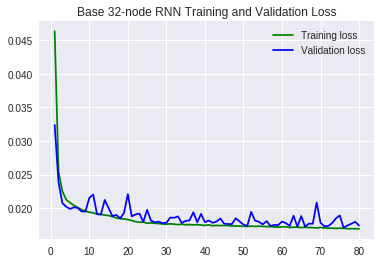

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Base 32-node RNN Training and Validation Loss')
plt.legend()
plt.show()

In [0]:
print('Train MAE = %f\nValidation MAE = %f' % ((train_loss[-1] * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (val_loss[-1] * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.798748
Validation MAE = 1.852958


In [0]:
model.save('/content/gdrive/My Drive/python/base-rnn-nomask-32-val.h5')

## Base RNN Model (64 nodes)

In [0]:
model = Sequential()
model.add(layers.GRU(64, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [0]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [0]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=80,
                              validation_data=gen_val,
                              workers=4, use_multiprocessing=True, shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/80
142/143 [============================>.] - ETA: 0s - loss: 0.0363 - mean_absolute_percentage_error: 23.5686

143/143 [==============================] - 71s 495ms/step - loss: 0.0361 - mean_absolute_percentage_error: 23.5099 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 13.6558
Epoch 2/80
143/143 [==============================] - 71s 498ms/step - loss: 0.0250 - mean_absolute_percentage_error: 17.2697 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 13.6022
Epoch 3/80
143/143 [==============================] - 71s 498ms/step - loss: 0.0226 - mean_absolute_percentage_error: 15.6720 - val_loss: 0.0211 - val_mean_absolute_percentage_error: 10.9018
Epoch 4/80
143/143 [==============================] - 71s 494ms/step - loss: 0.0212 - mean_absolute_percentage_error: 14.6452 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 10.9984
Epoch 5/80
143/143 [==============================] - 71s 498ms/step - loss: 0.0205 - mean_absolute_percentage_error: 14.1730 -

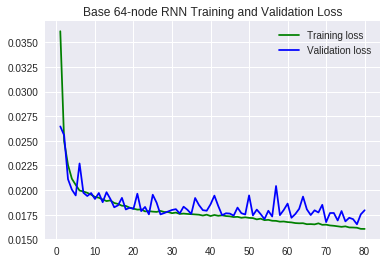

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Base 64-node RNN Training and Validation Loss')
plt.legend()
plt.show()

In [0]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.707605
Validation MAE = 1.757833


In [0]:
model.save('/content/gdrive/My Drive/python/base-rnn-nomask-64-val.h5')

## Base RNN Model (2x64)

In [0]:
model = Sequential()
model.add(layers.GRU(64, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(64))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [0]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [16]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=120,
                              validation_data=gen_val,
                              workers=4, use_multiprocessing=True, shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/120
143/143 [==============================] - 137s 956ms/step - loss: 0.0387 - mean_absolute_percentage_error: 25.1316 - val_loss: 0.0288 - val_mean_absolute_percentage_error: 13.1936
Epoch 2/120
143/143 [==============================] - 134s 936ms/step - loss: 0.0262 - mean_absolute_percentage_error: 18.0088 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 14.6649
Epoch 3/120
143/143 [==============================] - 134s 935ms/step - loss: 0.0232 - mean_absolute_percentage_error: 15.9769 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 10.6664
Epoch 4/120
143/143 [==============================] - 135s 941ms/step - loss: 0.0224 - mean_absolute_percentage_error: 15.1242 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 12.2627
Epoch 5/120
143/143 [==============================] - 135s 942ms/step - loss: 0.0220 - mean_absolute_percentage_error: 14.8891 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 10.5323
Epoch 6/120
143/143 [==============

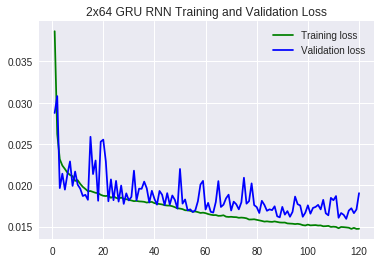

In [17]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('2x64 GRU RNN Training and Validation Loss')
plt.legend()
plt.show()

In [18]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.564980
Validation MAE = 1.694704


In [19]:
as5_train_preds = model.predict_generator(gen_train, workers=4, use_multiprocessing=True)
as5_train_preds.shape

(18304, 1)

In [20]:
as5_train_preds_withnan = np.full((as5_train_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_split)):
    if as5_train_split[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(20000, 1)

In [21]:
as5_val_preds = model.predict_generator(gen_val, workers=4, use_multiprocessing=True)
as5_val_preds.shape

(11223, 1)

In [22]:
as5_val_preds_withnan = np.full((as5_val_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_split)):
    if as5_val_split[i, 0] > -1:
        as5_val_preds_withnan[i] = as5_val_preds[j]
        j += 1
as5_val_preds_withnan.shape

(11616, 1)

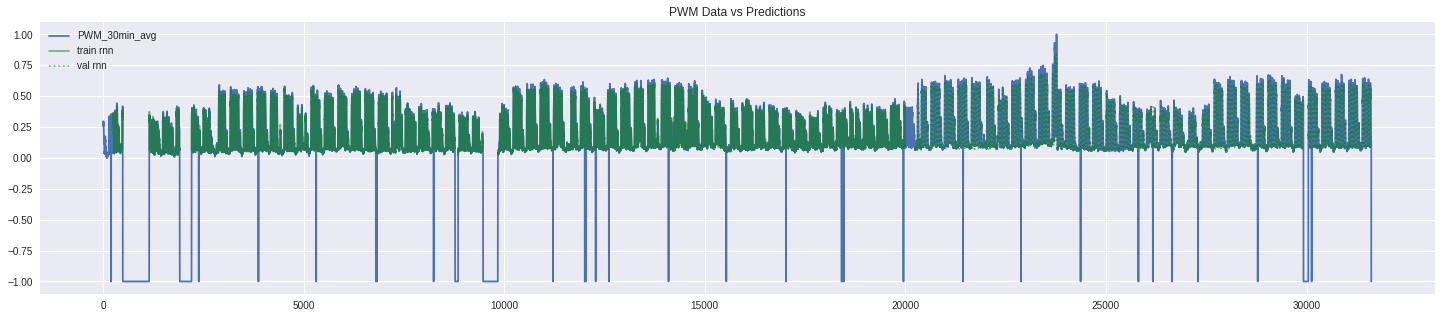

In [23]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_split.shape[0]), as5_train_preds_withnan.flatten(), color='green', alpha=.5, label='train rnn')
plt.plot(range(20000, 20000 + as5_val_split.shape[0]), as5_val_preds_withnan.flatten(), color='green', alpha=.5, label='val rnn', linestyle=':')
plt.title('PWM Data vs Predictions')
plt.legend()

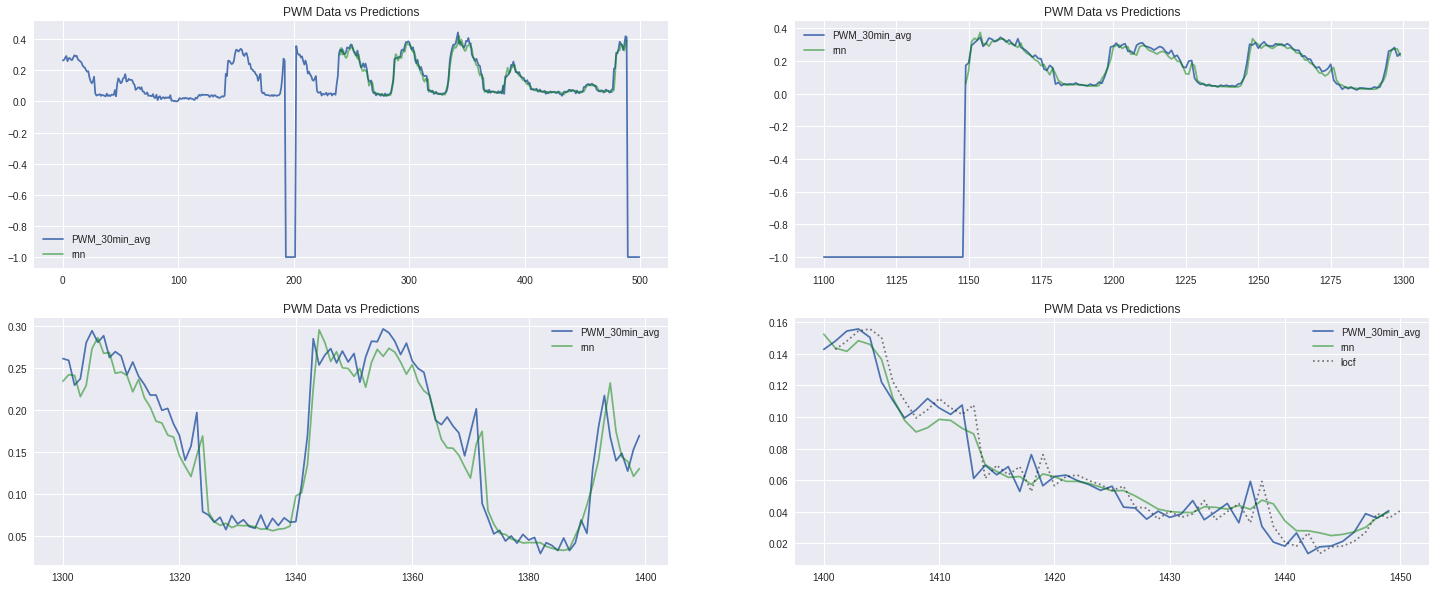

In [24]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(500), as5_train_data[:500, 0], label='PWM_30min_avg')
plt.plot(range(500), as5_train_preds_withnan[:500, :].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1100, 1300), as5_train_data[1100:1300, 0], label='PWM_30min_avg')
plt.plot(range(1100, 1300), as5_train_preds_withnan[1100:1300].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(1300, 1400), as5_train_data[1300:1400, 0], label='PWM_30min_avg')
plt.plot(range(1300, 1400), as5_train_preds_withnan[1300:1400].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(1400, 1450), as5_train_data[1400:1450, 0], label='PWM_30min_avg')
plt.plot(range(1400, 1450), as5_train_preds_withnan[1400:1450].flatten(), color='green', alpha=.5, label='rnn')
plt.plot(range(1401, 1451), as5_train_data[1400:1450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('PWM Data vs Predictions')
plt.legend()

In [0]:
model.save('/content/gdrive/My Drive/python/base-rnn-nomask-2x64-val.h5')

## Base RNN (3x64 nodes)

In [0]:
model = Sequential()
model.add(layers.GRU(64, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(64))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [0]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [0]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=120,
                              validation_data=gen_val,
                              workers=4, use_multiprocessing=True, shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('2x64 GRU RNN Training and Validation Loss')
plt.legend()
plt.show()

In [0]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

In [0]:
as5_train_preds = model.predict_generator(gen_train, workers=4, use_multiprocessing=True)
as5_train_preds.shape

In [0]:
as5_train_preds_withnan = np.full((as5_train_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_split)):
    if as5_train_split[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

In [0]:
as5_val_preds = model.predict_generator(gen_val, workers=4, use_multiprocessing=True)
as5_val_preds.shape

In [0]:
as5_val_preds_withnan = np.full((as5_val_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_split)):
    if as5_val_split[i, 0] > -1:
        as5_val_preds_withnan[i] = as5_val_preds[j]
        j += 1
as5_val_preds_withnan.shape

In [0]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_split.shape[0]), as5_train_preds_withnan.flatten(), color='green', alpha=.5, label='train rnn')
plt.plot(range(20000, 20000 + as5_val_split.shape[0]), as5_val_preds_withnan.flatten(), color='green', alpha=.5, label='val rnn', linestyle=':')
plt.title('PWM Data vs Predictions')
plt.legend()

In [0]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(500), as5_train_data[:500, 0], label='PWM_30min_avg')
plt.plot(range(500), as5_train_preds_withnan[:500, :].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1100, 1300), as5_train_data[1100:1300, 0], label='PWM_30min_avg')
plt.plot(range(1100, 1300), as5_train_preds_withnan[1100:1300].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(1300, 1400), as5_train_data[1300:1400, 0], label='PWM_30min_avg')
plt.plot(range(1300, 1400), as5_train_preds_withnan[1300:1400].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(1400, 1450), as5_train_data[1400:1450, 0], label='PWM_30min_avg')
plt.plot(range(1400, 1450), as5_train_preds_withnan[1400:1450].flatten(), color='green', alpha=.5, label='rnn')
plt.plot(range(1401, 1451), as5_train_data[1400:1450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('PWM Data vs Predictions')
plt.legend()

In [0]:
model.save('/content/gdrive/My Drive/python/base-rnn-nomask-3x64-val.h5')